<a href="https://colab.research.google.com/github/cartoscience/gee-tutorials/blob/main/SupervisedClassificationGEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervised Classification and Local Outlier Filtering with Google Earth Engine**

This exercise was put together as part of the Machine Learning for Science (ML4SCI) Hackathon: https://github.com/ML4SCIHackathon/ML4SCI. The exercise was prepared by Dr. Brad G. Peter in the Department of Geography at the University of Alabama.

The purpose of this objective is to learn how to create and troubleshoot supervised land-use/land-cover (LULC) classifications using Google Earth Engine (GEE). This task presents one way in which a multispectral image can be manipulated prior to classification in an attempt to refine model accuracy. The example below is for testing purposes only and is meant to inspire creative problem solving for improving the overall accuracy of LULC models.

For more documentation on supervised classifications visit https://developers.google.com/earth-engine/guides/classification. Not covered here, but also of relevance is unsupervised classifications. For details on this topic visit https://developers.google.com/earth-engine/guides/clustering.

---
Google Earth Engine is openly accessible and offers access to a large suite of geoprocessing tools and an extensive geospatial data catalog, but it does require an account. If you haven’t already, sign up for an account using a Gmail address—visit https://earthengine.google.com/. I recommend taking a stroll through this website to become familiar with some of Google Earth Engine’s capabilities. There are many new studies leveraging the capabilities of GEE, some of which are featured at https://earthengine.google.com/case_studies/.

 Once you've signed up, head over to https://code.earthengine.google.com/ to interact with the code editor. 
The full API can be accessed at https://developers.google.com/earth-engine/api_docs and there is a great intro to coding with GEE at https://developers.google.com/earth-engine/tutorials/community/beginners-cookbook.

**Task 1** - Adding geometries to set boundaries for image data extraction. 

Add this block to your code editor. The point will be used to isolate image tiles around the Austin, Texas area and the boundary geometry will be used to clip the extent.

In [ ]:
var point = ee.Geometry.Point([-97.75652736866604, 30.287326928802763])
var bounds = ee.Geometry.Polygon(
  [[[-97.90557204499963, 30.366990823768905],
    [-97.90557204499963, 30.238939859500963],
    [-97.33634291902307, 30.238939859500963],
    [-97.33634291902307, 30.366990823768905]]], null, false)



---



**Task 2** - Loading the USGS National Land Cover Database (NLCD)—https://developers.google.com/earth-engine/datasets/catalog/USGS_NLCD and retrieving map projection information.

Use this code block to load NLCD for the year 2016 and remap the LULC categories to new values ranging from 0–19. The purpose of this remapping is to make visualizations consistent across products later in the script.

In [ ]:
var nlcd2016 = ee.Image("USGS/NLCD/NLCD2016").select('landcover')
  .remap([11,12,21,22,23,24,31,41,42,43,51,52,71,72,73,74,81,82,90,95],
         [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])
  .rename('landcover')

var prj = nlcd2016.projection()



---



**Task 3** - Loading USGS Landsat 8 Surface Reflectance Tier 1 imagery—https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR.

In this section, we'll first sort the Landsat 8 image collection by the 'CLOUD_COVER' property to retrieve the least cloudy image for 2016. Afterward, we'll use the bitmask QA band to remove any remaining cloud cover.

In [ ]:
var collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
  .filterBounds(point).filterDate('2016-01-01', '2016-12-31')

var image = collection.sort('CLOUD_COVER').first()

var qa = image.select('pixel_qa')
var cloudMask = qa.bitwiseAnd(1<<5).eq(0)
  .and(qa.bitwiseAnd(1<<3).eq(0))
var masked = image.updateMask(cloudMask).clip(bounds).reproject(prj)

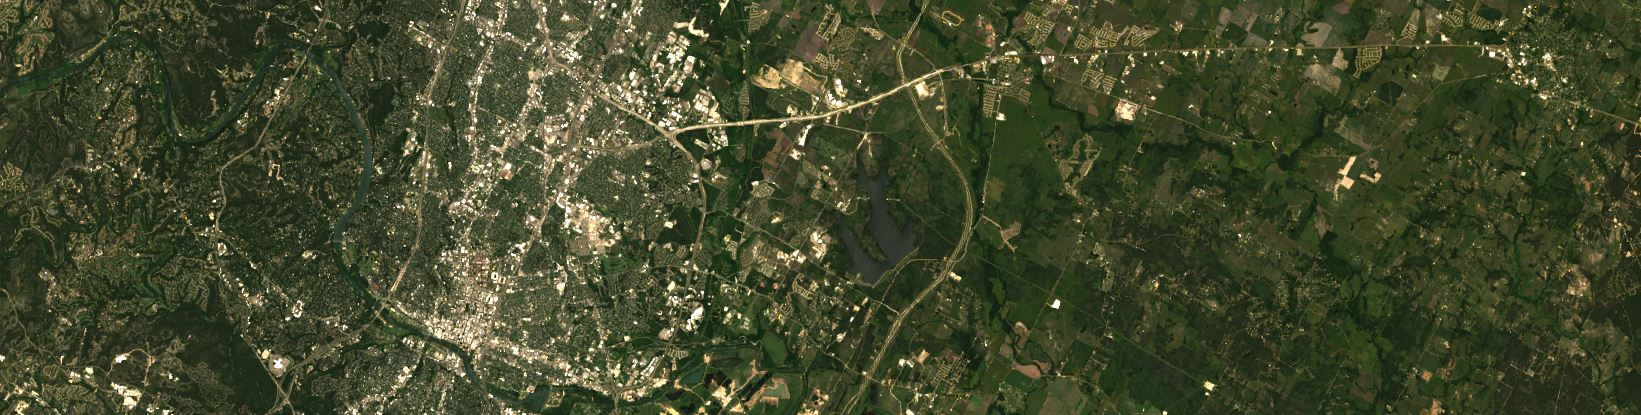

**Task 4** - Add NLCD 2016 data and the Landsat 8 image to the display and center the map to the boundary polygon.

In [ ]:
nlcd2016 = nlcd2016.clip(bounds)
image = image.clip(bounds)

var classColors = [
  '476ba1','d1defa','decaca','d99482','ee0000',
  'ab0000','b3aea3','68ab63','1c6330','b5ca8f',
  'a68c30','ccba7d','e3e3c2','caca78','99c247',
  '78ae94','dcd93d','ab7028','bad9eb','70a3ba'
]

Map.addLayer(image,{min:0,max:2500,bands:['B4','B3','B2']},'true color image',false)
Map.addLayer(nlcd2016,{min:0,max:19,palette:classColors},'nlcd 2016',false)
Map.centerObject(bounds).setOptions('HYBRID')

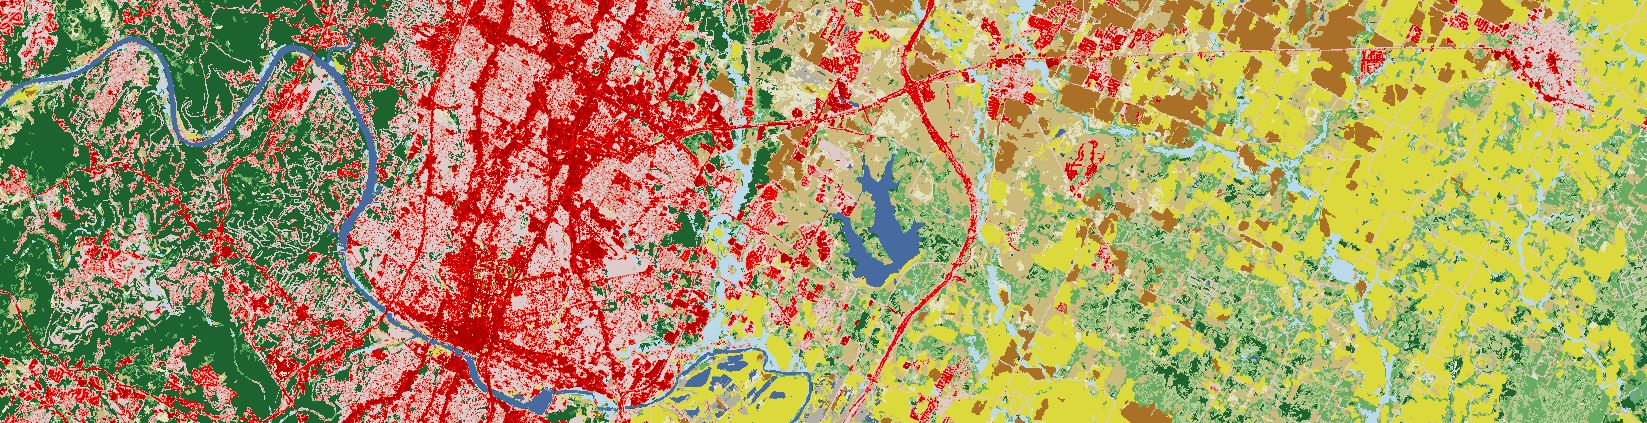



---



## **Supervised Classification Parameterization**

**Task 5** - Setting and modifying the classification model parameters.

This section is where many adjustments can be made. Note that by default only bands 'B2', 'B3', and 'B4' have been included here, which corresponde with blue, green, and red spectral reflectances, respectively. If you check the Landsat 8 SR metadata (linked above), you will see there are other bands available for use, namely near infrared ('B5'), shortwave infrared ('B6' and 'B7'), and brightness temperature ('B10' and 'B11'). 

Check the GEE documentation for other classification systems, e.g., classification and regression tree (CART) and support vector machine (SVM). Also available for modification are the sample size, kernel size, kernel type, and the threshold used for categorizing outliers. The default parameters and classification set here are not optimized and the challenge is for you to test alternative methods and parameters.

In [ ]:
var bands = ['B2','B3','B4']
var classifier = ee.Classifier.smileRandomForest(10)
var sampleSize = 2500
var kernelSize = 7
var outlierThreshold = 3.5

var kernel = ee.Kernel.square({
  radius:kernelSize,
  units:'pixels'
})

**Task 6** Executing the classification using a training sample and evaluating the model accuracy using a confusion matrix.

In [ ]:
var training = masked.addBands(nlcd2016).sample({
  numPixels: sampleSize,
  seed: 0
})

var classifier = classifier.train({
  features: training,
  classProperty: 'landcover',
  inputProperties: bands
})

var classified = masked.classify(classifier)

print('// Base classification -----')
var trainAccuracy = classifier.confusionMatrix()
print('Resubstitution error matrix: ', trainAccuracy)
print('Training overall accuracy: ', trainAccuracy.accuracy())

**Task 7** - Evaluating model accuracy against a validation sample using a confusion matrix. 

In [ ]:
var validation = masked.addBands(nlcd2016).sample({
  numPixels: sampleSize,
  seed: 1
}).filter(ee.Filter.neq('B1', null))

var validated = validation.classify(classifier)

var testAccuracy = validated.errorMatrix('landcover', 'classification')
print('Validation error matrix: ', testAccuracy)
print('Validation overall accuracy: ', testAccuracy.accuracy())

Map.addLayer(classified,{min:0,max:19,palette:classColors},'classification',false)

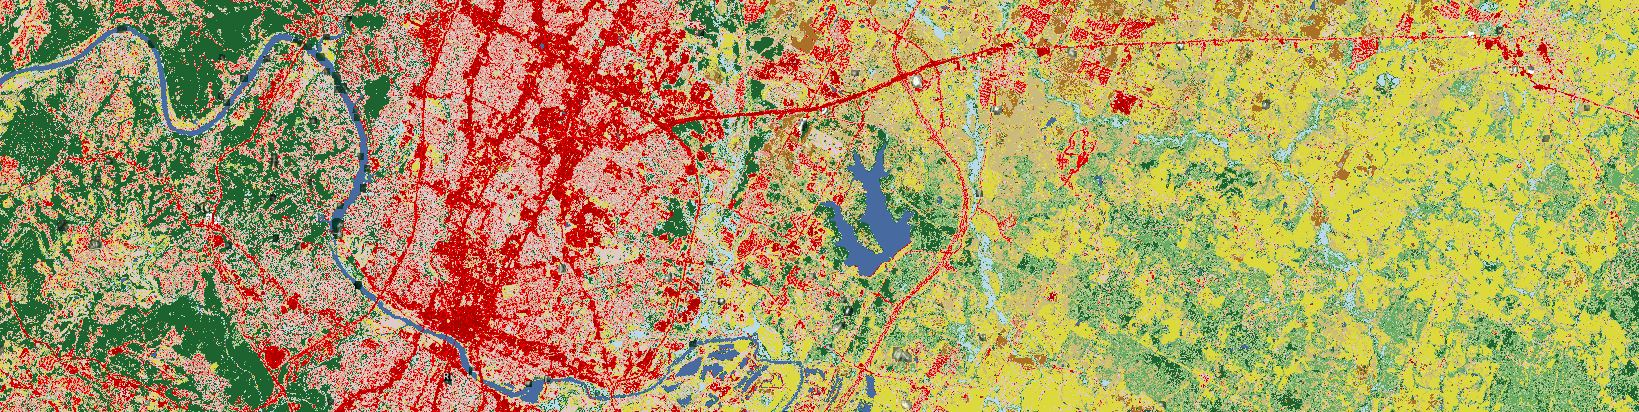

**Task 8** - Focal statistics are one way to identify and fill local spatial data outliers. In this case, you are presented with the modified z-score (Iglewicz and Hoaglin 1993), but you are encouraged to test alternative methods. In fact, this method might only show marginal model improvement in some test cases. Your challenge is to explore other ways of manipulating the starting dataset to improve model accuracy post-classification.

Iglewicz, B. and Hoaglin, D.C., 1993. *How to detect and handle outliers* (Vol. 16). Asq Press.

In [ ]:
var focalStat = masked.focal_median({kernel:kernel}).reproject(prj)
var diff = masked.subtract(focalStat)
var mzscore = diff.multiply(0.6745).divide(diff.abs().focal_median({kernel:kernel}).reproject(prj))
var con = mzscore.gt(outlierThreshold) // Outlier threshold selection
var filtered = masked.where(con.eq(1),focalStat)

**Task 9** - Repeating tasks 6 and 7 with the filtered image data.

In [ ]:
var training = filtered.addBands(nlcd2016).sample({
  numPixels: sampleSize,
  seed: 0
})

var classifier = classifier.train({
  features: training,
  classProperty: 'landcover',
  inputProperties: bands
})

var classified = masked.classify(classifier)

var trainAccuracy = classifier.confusionMatrix()
print('// Filtered classification -----')
print('Resubstitution error matrix: ', trainAccuracy)
print('Training overall accuracy: ', trainAccuracy.accuracy())

var validation = filtered.addBands(nlcd2016).sample({
  numPixels: sampleSize,
  seed: 1
}).filter(ee.Filter.neq('B1', null))

var validated = validation.classify(classifier)

var testAccuracy = validated.errorMatrix('landcover', 'classification')
print('Validation error matrix: ', testAccuracy)
print('Validation overall accuracy: ', testAccuracy.accuracy())

Map.addLayer(classified,{min:0,max:19,palette:classColors},'classification filtered',false)

## **Results submission**

Requirements for submitting your results:

*   Link to GEE script (use the 'Get Link' button at the top of your code editor)
*   Bands selected for parameterization
*   Classification method selected
*   Sample size selected
*   Kernel size/type
*   Outlier threshold
*   Rationale for each of the parameters set
*   Highest overall training/test accuracy from the confusion matrix output
*   If you used a method other than what was supplied here, please detail your methods and results.
